#### This python notebook looks at the relationship between stages of the Monsoon (burst) and Extreme Events

In [9]:
import pandas as pd
import numpy as np
import xarray as xr
from netCDF4 import Dataset as nc, num2date, MFDataset as mc, date2num
import os
import pytz
from matplotlib import pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
sns.set_style("whitegrid")
from DataFrame import *
from datetime import datetime
from astropy.stats import LombScargle
import astropy.units as u
from scipy import signal
import matplotlib, sys
from mpl_toolkits.basemap import Basemap, cm as colmap
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [30.0,30.0]
from collections import namedtuple
timezone = pytz.timezone('Australia/Darwin')
utc = pytz.UTC
from matplotlib import animation, rc

Define the path's where data is storde

In [2]:
CPOL = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_TIWI_1998-2017.nc')
WOHF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOH.nc')
WOHFv1 = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOHv1.nc')
WOHFv2 = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOHv2.nc')
BurstF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_burst-cmorph.pkl')
PercF = os.path.join(os.environ['HOME'],'Data','Extremes','CPOL','CPOL_TIWI_Percentiles.hdf5')
extremeTS = os.path.join(os.environ['HOME'],'Data','Extremes','CPOL','CPOL_TIWI_TS_extrme.pkl')
percf =  os.path.join(os.environ['HOME'],'Data','Extremes','CPOL', 'Periods.npz')
outdir = os.path.join(os.getenv('HOME'),'Data','Extremes','CPOL', 'Plot', 'Versions')

## 1.0 Climatology of rainfall and the importance of the diurnal cycle
To investigate the links between Monsoon stage and Rainfall extremes in the considered area it is worthwhile having a look at the general climatology of rainfall and investigate the importance of the diurnal cycle in the stduy domain. 

The relative importance of the diurnal cycle is investigated in two ways:
* Calculating the fraction of total variability each frequency for the spectral density of the domain avg. rain-rates
* Presenting a map the fraction of variability for the 1/24h frequncy band of the spectral density at each grid-point



In [3]:
# First get the domain avg rain-rates, the domain co-ordinates and the time-vector for the cpol era
with nc(CPOL) as fnc:
    rr = fnc['10min'].variables['rain-rate'][:]
    times = num2date(fnc['10min'].variables['time'][:], fnc['10min'].variables['time'].units)
    T = date2num(times, times[0].strftime('Days since %Y-%m-%d %H:%M:%S'))
    lon=fnc.variables['lon'][:]
    lat=fnc.variables['lat'][:]
    rr_tavg = fnc['6h'].variables['rain-rate'][:].mean(axis=0)
rr_aavg = pd.Series(rr.mean(axis=(1,2)), index=T)

In [4]:
#Create the map for plotting
m = Basemap(llcrnrlat=min(lat), llcrnrlon=min(lon), urcrnrlat=max(lat), urcrnrlon=max(lon), resolution='f',
            area_thresh=1)


#### Calculate the fraction of total spectral variance
Because the cpol data contains holes (missing data) we chose to create a Lomb-Scargle periodigram rather than a 
a fourier decomposition of the data. Lomb-Scargle periodigrams are created by least-spaure fitting sinosoids to the data. The LombScargle Class provided by astropy's stats module will create the periodogram. For best practice we create a function that calculates the fraction of the spectral variance.

In [5]:
def get_psd(data, t, freq=1):
    '''Calculate the fraction of power for each freq in the spectrum of a given TS
       data = the time-series
       freq = return only the fraction for a given freq. band
       step = sample freq in minutes
    '''
    f, power = LombScargle(t, data, 1).autopower(minimum_frequency=0.01667, maximum_frequency=3.5, method='fast')
    if freq is None:
        return 1/f, power/power.sum() * 100
    else:
        nn = np.argmin(np.fabs(1/f-freq))
        return power[nn-2:nn+2].sum()/power.sum() * 100

Calculate the psd for the area total avg rain-rates first

In [6]:
rr_aavg = rr_aavg.loc[rr_aavg>0]
f, psd = get_psd(rr_aavg.dropna().values, rr_aavg.dropna().index, freq=None)

Now calculate the map of spectral variance in the diurnal cycle

In [7]:
mask = np.ma.masked_less_equal(rr.sum(axis=0),0.1)*0 + 1
spec_map = np.zeros([len(lat), len(lon)]) * mask
create = False
if not os.path.isfile(percf) or create:
    for i in range(len(lat)):
        for j in range(len(lon)):
            if not spec_map.mask[i,j]:
                sys.stdout.flush()
                sys.stdout.write('\r Calculating TS for : %0.2f, %0.2f'%(lat[i],lon[j]))
                sys.stdout.flush()
                rr_tmp = pd.Series(rr[:,i,j].filled(np.nan), index=T).dropna()
                rr_tmp = rr_tmp.loc[rr_tmp>0]
                spec_map[i,j] = get_psd(rr_tmp.values, rr_tmp.index, freq=1)
        
    np.savez_compressed(percf, perc=spec_map.filled(-99))
else:
    print()
    spec_map = np.ma.masked_less(np.load(percf)['perc'], 0)
sys.stdout.write('\n')

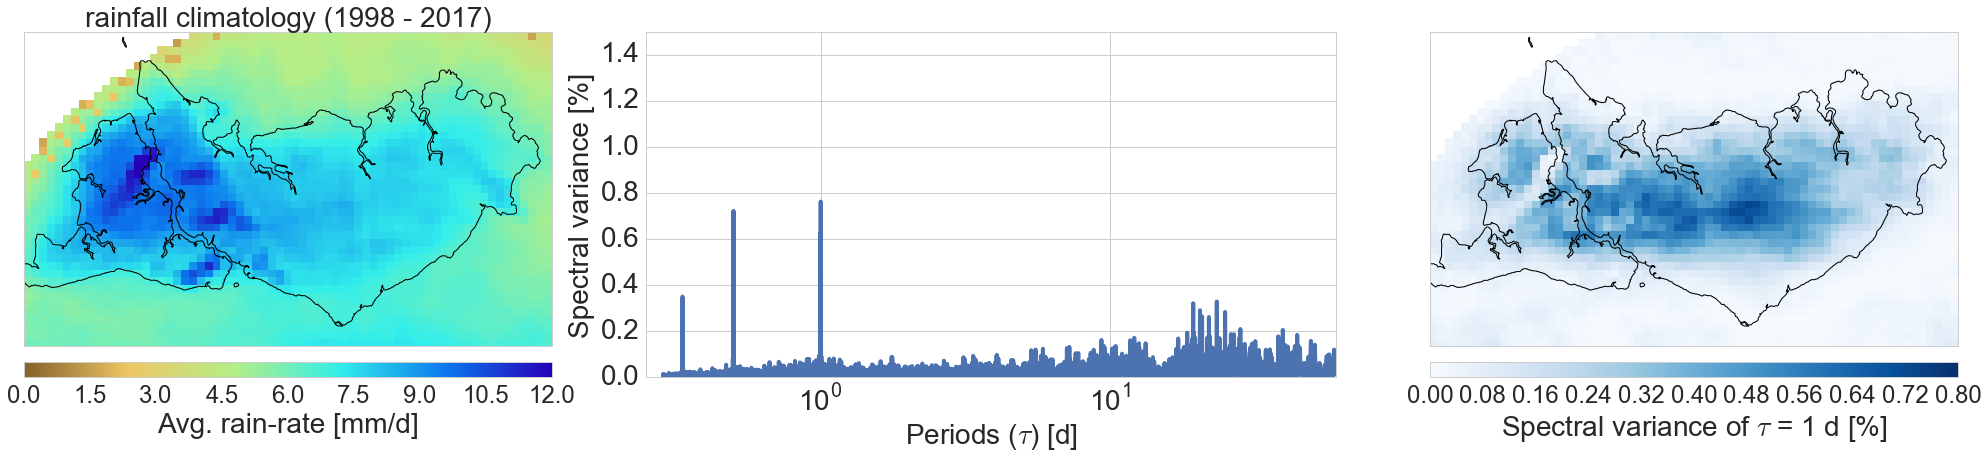

In [10]:
#Plot the output map
fig = plt.figure()
#ax1 = fig.add_subplot(111)
ax1 = fig.add_subplot(131)
ax1.set_title('rainfall climatology (1998 - 2017)', size=28)
im = m.pcolormesh(lon, lat, mask * rr_tavg * 24, vmin=0, vmax=12, cmap=colmap.GMT_drywet, ax=ax1)
m.drawcoastlines()
cbar = m.colorbar(im,location='bottom',pad="5%")
cbar.set_label('Avg. rain-rate [mm/d]', size=28)
cbar.ax.tick_params(labelsize=24)
#'''
ax2 = fig.add_subplot(132)
ax2.semilogx(f, psd * 9, lw=4)
ax2.set_xlim(0.25,60)
ax2.set_ylim(0,1.5)
ax2.set_xlabel('Periods ($\\tau$) [d]',size=28)
ax2.set_ylabel('Spectral variance [%]',size=28)
ax2.tick_params(labelsize=28)
ax3 = fig.add_subplot(133)
im2 = m.pcolormesh(lon, lat, np.ma.masked_invalid(spec_map)*2 , vmin=0, vmax=0.8,cmap='Blues', ax=ax3)
m.drawcoastlines()
cbar = m.colorbar(im2,location='bottom',pad="5%")
cbar.set_label('Spectral variance of $\\tau$ = 1 d [%]', size=28)
cbar.ax.tick_params(labelsize=24)
fig.subplots_adjust(right=0.98, bottom=0.83, top=0.99,left=0.01, hspace=0.05, wspace=0.02)
#'''

## 2.0 The Link between local Extemes and the stage of the Monsoon

The above plots show that diurnal cycle is the most important mode of variability in the considered area. The island thunderstrom hector is the most extreme convective system that occurs at the time-scale at perdiods of 24 h. The Hector 'signal' is most pronounced during the Monsoon break period. Before studying Hector we split the CPOL area into *break* and *burst* period and investigate the occurrence of extremes during Monsoon *break* and *burst*. 

First we define extreme events by applying the 99th percentile threshold of the total 10min dataset.  

In [11]:
perc = pd.read_hdf(PercF, 'all')
create = False
if not os.path.isfile(extremeTS) or create:
    with pd.HDFStore(extremeTS,'w') as h5:
        for gr in ('10min','1h','3h','6h','24h'):
            if gr =='10min':
                thresh = 1
            else:
                thresh = 75
            h5['/P%s'%gr] = get_extremeTS(CPOL,gr,perc[gr].loc[99], thresh, varname='rain-rate')

### 2.1 Maps of Break -  Burst comparison for the CPOL data
Now we define the break and burst events by the definition of Narsey et al. and calculate the number of burst and the number of break events during the CPOL era

In [12]:
extr1h = pd.read_hdf(extremeTS, 'P10min')
monsoon10m = pd.read_pickle(BurstF)
monsoon10m = monsoon10m.dropna()
monsoon1h = monsoon10m.groupby(pd.TimeGrouper('1h')).mean()
breaks = monsoon10m.loc[monsoon10m == 0].index
bursts = monsoon10m.loc[monsoon10m > 0].index
thresh = perc['10min'][99]
S = pd.Series(np.arange(len(times)),index=times)
print('Bursts: %0.2f %% Breaks: %0.2f %%' 
      %(len(bursts)/len(monsoon10m.index) * 100, len(breaks)/len(monsoon10m.index) * 100 ))

Bursts: 39.73 % Breaks: 60.27 %


In [13]:
#Now prepare the data
D = []
data = np.zeros([len(lat),len(lon)])
for i in (monsoon10m.index, breaks, bursts):
    tt = S.loc[i].dropna().values.astype('i')
    D.append((( np.ma.masked_less(rr[tt,:,:],thresh) * 0 ) + 1 ).sum(axis=0))
mask = ((D[0] * 0 )+1)

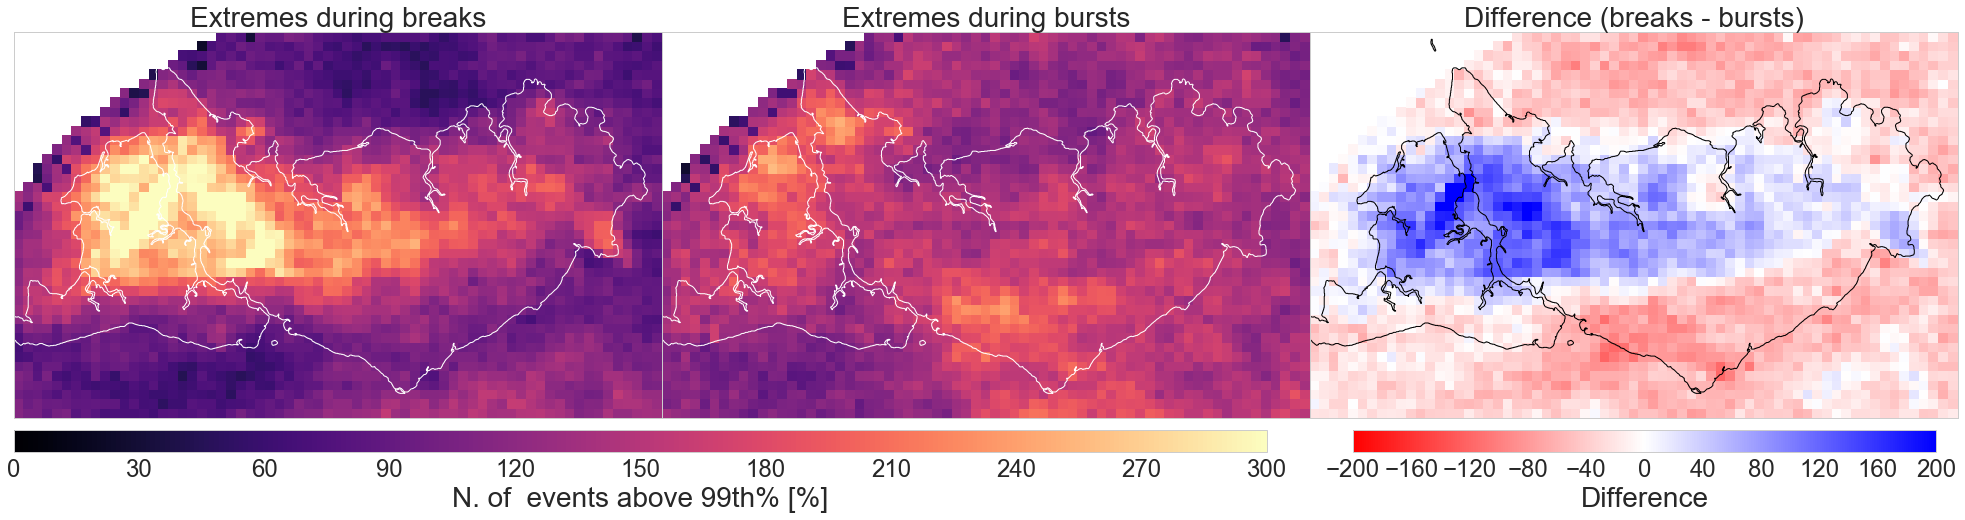

In [14]:
# Now Plot the maps
maxval =[(0, 300), (0, 300), (-200, 200), (-200, 200)]
names=['Extremes during breaks', 'Extremes during bursts', 'Difference (breaks - bursts)']

C = [D[1], D[2], D[1] - D[2]]
fig = plt.figure()
mask = ((D[0] * 0 )+1)
im=[]
for i, idx in enumerate(C[:]):
    ax = fig.add_subplot(1,3,i+1)
    data = np.zeros([len(lat),len(lon)])
    if i < 2:
        colm = mpl.cm.magma
        coast = 'w'
    else:
        colm = colmap.GMT_polar_r
        coast = 'k'
    #tt = S.loc[time].values
    #data = (( np.ma.masked_less(rr[:,:,tt],thresh) * 0 ) + 1 ).sum(axis=-1)
    try:
        im.append(m.pcolormesh(lon, lat, mask*C[i].filled(0),vmin=maxval[i][0],vmax=maxval[i][1],cmap=colm))
    except AttributeError:
        im.append(m.pcolormesh(lon, lat, mask*C[i],vmin=maxval[i][0],vmax=maxval[i][1], cmap=colm))
    m.drawcoastlines(color=coast)
    #cbar=m.colorbar(im,location='bottom',pad='5%')
    #cbar.set_label(u'Freq. of events above 99th% [%]',size=18)
    #cbar.ax.tick_params(labelsize=18)
    ax.set_title('%s'%names[i],size=28)
fig.subplots_adjust(right=0.95, bottom=0.05, top=0.95,left=0.05, hspace=0, wspace=0)
cbar_ax1 = fig.add_axes([0.05, 0.395,0.58, 0.01])
cbar1 = fig.colorbar(im[1], cax=cbar_ax1, orientation='horizontal')
cbar1.ax.tick_params(labelsize=24)
cbar1.set_label(u'N. of  events above 99th% [%]',size=28)
cbar_ax2 = fig.add_axes([0.67, 0.395,0.27, 0.01])
cbar2 = fig.colorbar(im[-1], cax=cbar_ax2, orientation='horizontal')
cbar2.ax.tick_params(labelsize=24)
cbar2.set_label(u'Difference',size=28)

## 2.0 Week of Hector

To investigate how well Extreme Events caused by local tropicsl Island Thunderstorms are represented in a numerical model we choose a period of 8 consecutive occurring Hector events over the Tiwi Island during the Monsoon break period in November 2006. To increase the sample size for more robust statistics we create ensemble of 8 members. The ensemble is created by 8 different initialisation times. 

In [15]:
## First define the file names of the simulations
UMdir = os.path.join(os.getenv('HOME'), 'Data', 'Extremes', 'UM', 'darwin', 'RA1T')
ensembles = ('20061109T1200Z', '20061109T1800Z', '20061110T0000Z', '20061110T0600Z', '20061110T1200Z',
             '20061110T1800Z',  '20061111T0000Z', '20061111T1200Z')
Simend = '20061119_0600'
### Define the resolutions we have with help of a named tuple
Simulation = namedtuple('Simulation', 'member dataset resolution')
UM133 = Simulation(member=ensembles, dataset=[], resolution=1.33)
UM044 = Simulation(member=ensembles, dataset=[], resolution=0.44)
OBS = Simulation(member=['CPOL'], dataset=[], resolution=2.55)
# Now construct the filenames of the UM - rainfall ouput and get the overlapping time periods
start, end = [], []
for ens in ensembles:
    date = datetime.strptime(ens,'%Y%m%dT%H%MZ')
    umf133 = 'um-1p33km-%s-rain_%s-%s.nc' %(date.strftime('%m%d%H%M'), date.strftime('%Y%m%d_%H%M'), Simend)
    umf044 = 'um-0p44km-%s-rain_%s-%s.nc' %(date.strftime('%m%d%H%M'), date.strftime('%Y%m%d_%H%M'), Simend)
    time133 = xr.open_dataset(os.path.join(UMdir,ens,'darwin','1p33km', umf133)).coords['t'].values
    time044 = xr.open_dataset(os.path.join(UMdir,ens,'darwin','0p44km', umf044)).coords['t'].values
    start.append((time133[0], time044[0]))
    end.append((time133[-1], time044[-1]))
end = np.min(np.array(end), axis=0)
start = np.max(np.array(start), axis=0)
# Now get the datasets for these overlapping time periods
for nn, ens in enumerate(ensembles):
    date = datetime.strptime(ens,'%Y%m%dT%H%MZ')
    umf133 = 'um-1p33km-%s-rain_%s-%s.nc' %(date.strftime('%m%d%H%M'), date.strftime('%Y%m%d_%H%M'), Simend)
    umf044 = 'um-0p44km-%s-rain_%s-%s.nc' %(date.strftime('%m%d%H%M'), date.strftime('%Y%m%d_%H%M'), Simend)
    for file, res, ntuple, n in ((umf133, '1p33km', UM133, 0), (umf044, '0p44km', UM044, 1)):
        fn = os.path.join(UMdir, ens,'darwin', res, file)
        with xr.open_dataset(fn) as ds:
            um_times = pd.DatetimeIndex(ds.coords['t'].values).round('1min')
            iloc_s = abs(um_times - pd.Timestamp(start[n])).argmin()
            iloc_e = abs(um_times - pd.Timestamp(end[n])).argmin()
            
        ntuple.dataset.append(xr.open_dataset(fn).isel(t=list(range(iloc_s,iloc_e+1)), surface=[0]))
        ntuple.dataset[-1].coords['t'] = um_times[iloc_s:iloc_e+1].round('5min')
# Now get the overlapping time periods for the observations


for nn,file in enumerate((WOHF, WOHFv1, WOHFv2)):
    with nc(file) as ds:
        obs_time = pd.DatetimeIndex(num2date(ds.variables['t'][:], ds.variables['t'].units))
        iloc_s = abs(obs_time - pd.Timestamp(start[0])).argmin()
        iloc_e = abs(obs_time - pd.Timestamp(end[0])).argmin()

    ds = xr.open_dataset(file)
    ds.coords['t'] = obs_time
    if nn > 0:
        slon = np.fabs(ds.variables['longitude'].values[0,:] - min(lon)).argmin()
        elon = np.fabs(ds.variables['longitude'].values[0,:] - max(lon)).argmin()+1
        slat = np.fabs(ds.variables['latitude'].values[:,0] - min(lat)).argmin()
        elat = np.fabs(ds.variables['latitude'].values[:,0]- max(lat)).argmin()+1
        OBS.dataset.append(ds.isel(t=list(range(iloc_s, iloc_e+1)), y=range(slon,elon), x=range(slat,elat)))
    else:
        OBS.dataset.append(ds.isel(t=list(range(iloc_s, iloc_e+1))))

Now lets try concatenating the UM ensemble data into one big data-array to construct the percentiles and compare it to the CPOL observations. 

In [16]:
# Concatenate the um datasets
UM133ens = xr.concat(UM133.dataset, dim='ens')
UM044ens = xr.concat(UM044.dataset, dim='ens')

### 2.1 Simulation of rainfall
Now we compare the ensemble timeseries of the simulated rainfall for the 1.33km and 0.44km Simulations with the CPOL observations.


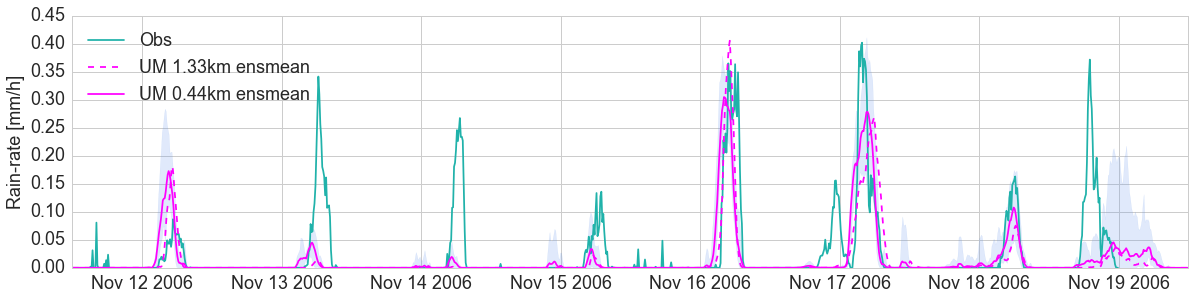

In [28]:
#Get the minimum time period that is covered by all simulations and also observations
fig = plt.figure(figsize=(20,10), dpi=72)
ax = fig.add_subplot(111)
## First plot the area avg of the cpol data
#ax.plot(OBS.dataset[0].coords['t'], np.nanmean(OBS.dataset[0].variables['lsrain'].values[:,0,:]*mask.filled(np.nan),axis=(1,2)), label='New Version (my concat)',
#        color='firebrick')
#ax.plot(OBS.dataset[-1].coords['t'], OBS.dataset[-1].variables['lsrain'].mean(axis=(1,2)), label='New Version',
#        color='firebrick', linestyle='--')
ax.plot(OBS.dataset[1].coords['t'], OBS.dataset[1].variables['lsrain'].mean(axis=(1,2)), linestyle='-',
        color='lightseagreen', label='Obs')
#############
ax.plot(UM133ens.coords['t'], UM133ens.variables['lsrain'].mean(axis=(0,2,3,4)), color='fuchsia',
        label='UM 1.33km ensmean', linestyle='--')
#ax.fill_between(UM133ens.coords['t'].values, 
#                UM133ens.variables['lsrain'].mean(axis=(2,3,4)).min(axis=0).values,
#                UM133ens.variables['lsrain'].mean(axis=(2,3,4)).max(axis=0).values, color='fuchsia',
#                alpha=0.2)
############
ax.plot(UM044ens.coords['t'], UM044ens.variables['lsrain'].mean(axis=(0,2,3,4)), color='fuchsia',
        label='UM 0.44km ensmean')
ax.fill_between(UM044ens.coords['t'].values, 
                UM044ens.variables['lsrain'].mean(axis=(2,3,4)).min(axis=0).values,
                UM044ens.variables['lsrain'].mean(axis=(2,3,4)).max(axis=0).values, color='cornflowerblue',
                alpha=0.2)
plt.subplots_adjust(bottom=0.05, right=0.9, top=0.4)
ax.legend(loc=0, fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylabel('Rain-rate [mm/h]', fontsize=18)


### Percentiles
Now get the percentiles for the ensemble simulation and compare it against the observations

In [42]:

OBS_perc = pd.read_hdf(PercF, 'break')['10min']
UM133_perc = np.nanpercentile(np.ma.masked_less_equal(UM133ens.variables['lsrain'][:],0.019).filled(np.nan), OBS_perc.index)
UM044_perc = np.nanpercentile(np.ma.masked_less_equal(UM044ens.variables['lsrain'][:],0.019).filled(np.nan), OBS_perc.index)
PERC = pd.DataFrame({'Obs':OBS_perc.values, 'UM 1.33km':UM133_perc, 'UM 0.44km':UM044_perc}, index=OBS_perc.index)

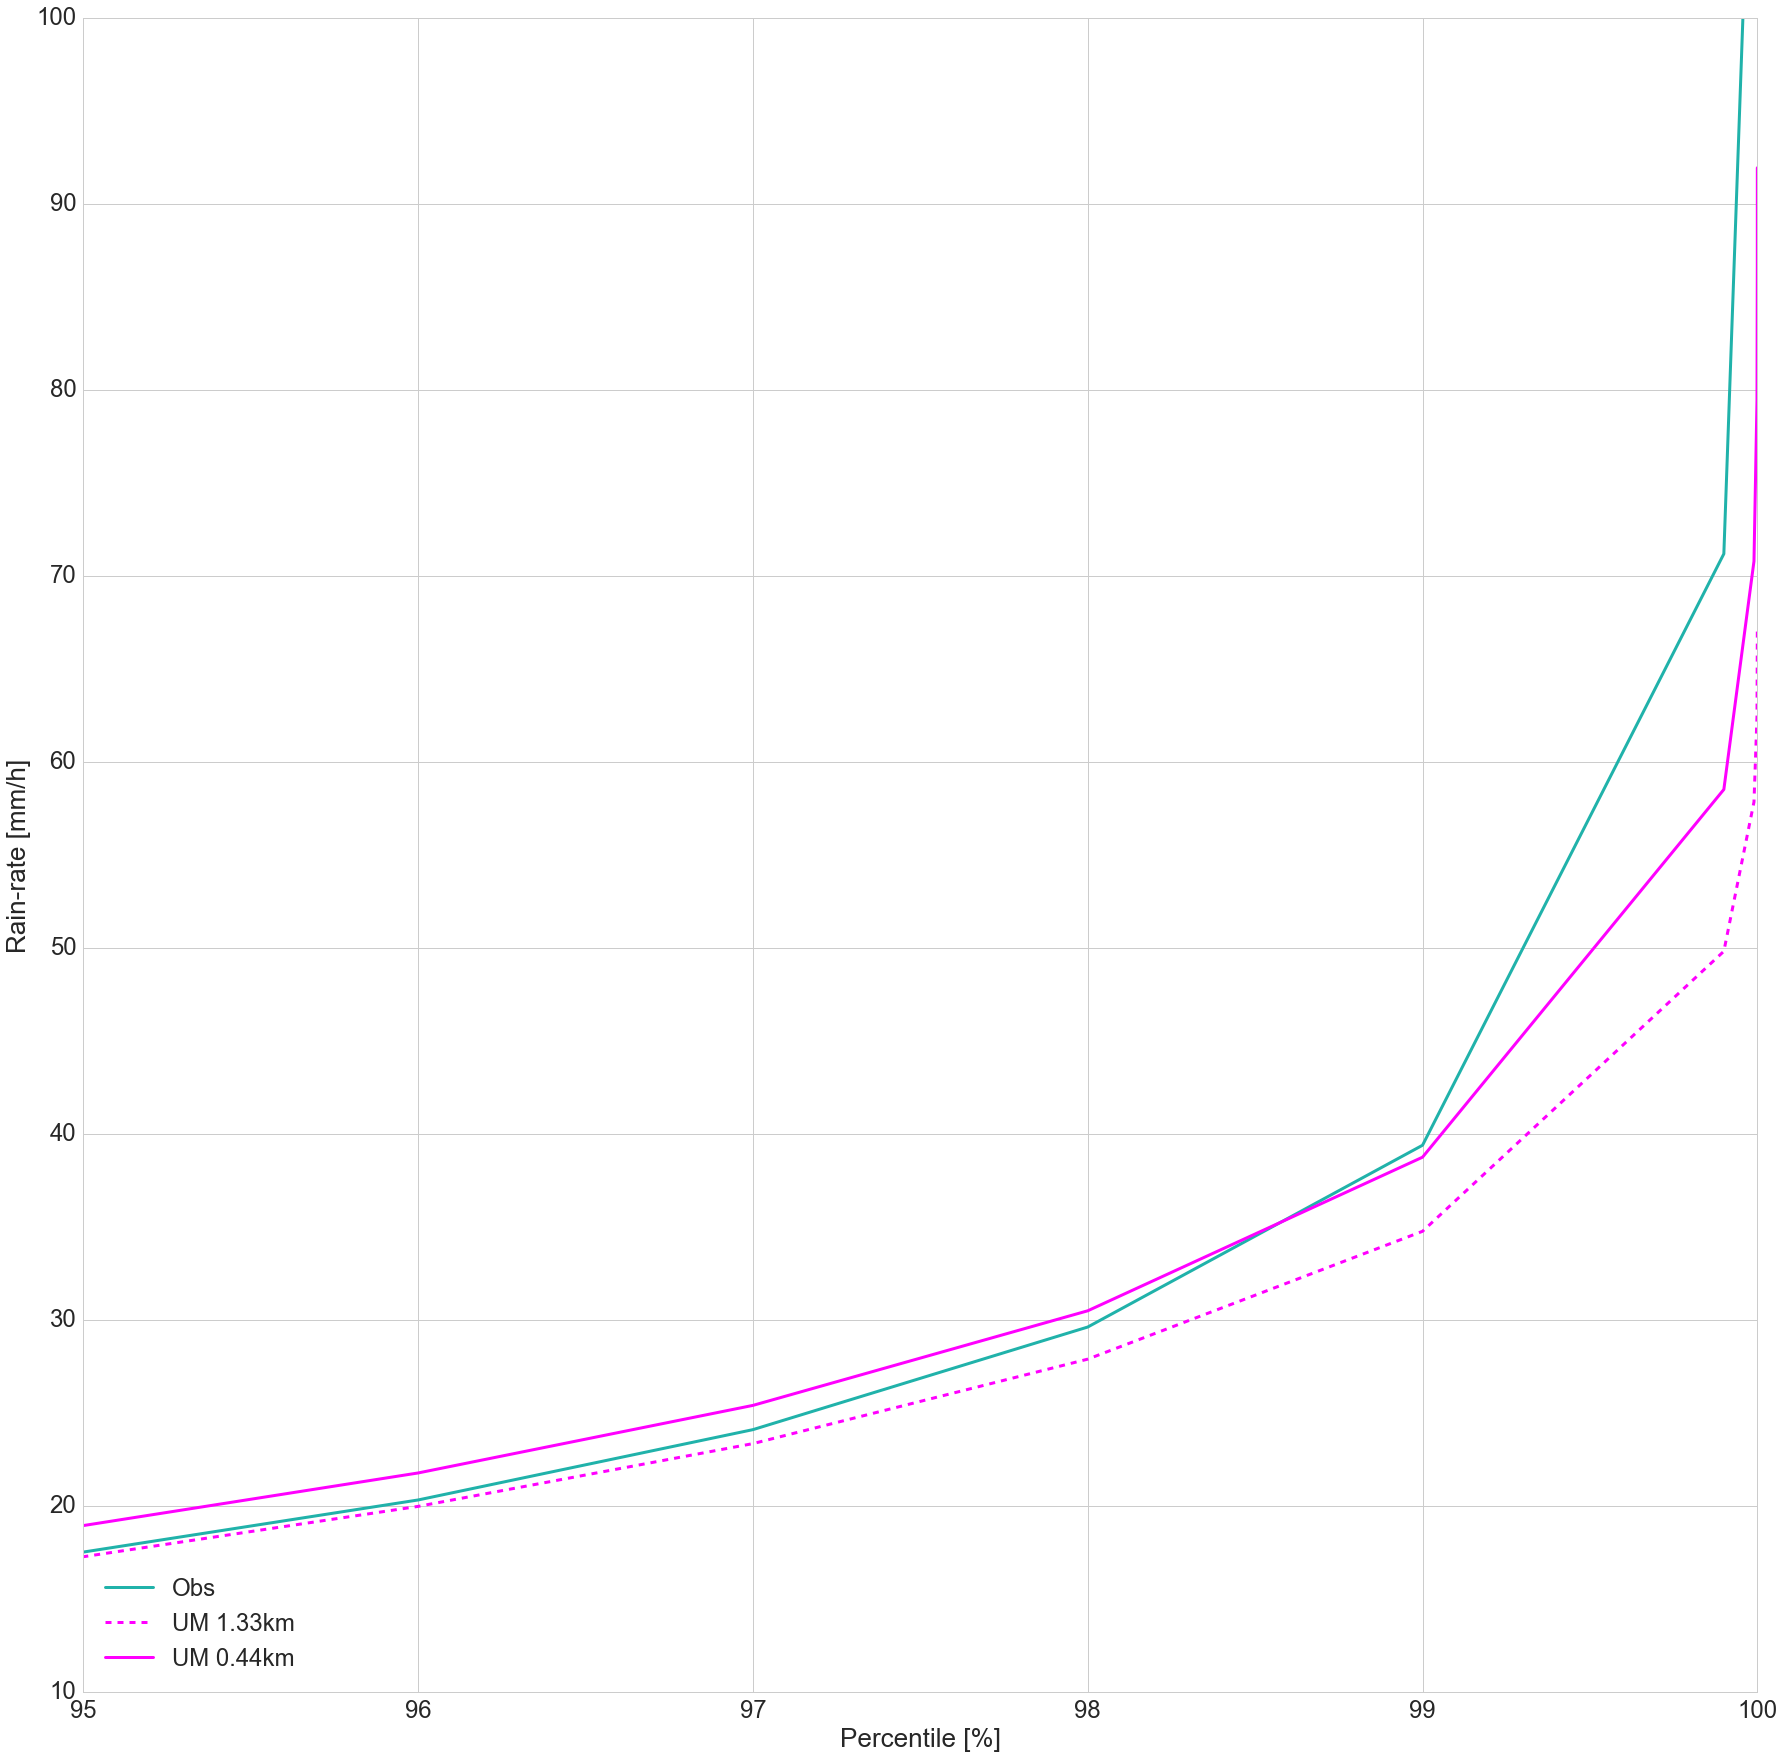

In [57]:
fig=plt.figure()
ax = fig.add_subplot(111)
ax.plot(PERC.index, PERC['Obs'].values, color='lightseagreen', linestyle='-', label='Obs',lw=3)
ax.plot(PERC.index, PERC['UM 1.33km'].values*1.5, color='fuchsia', linestyle='--', label='UM 1.33km',lw=3)
ax.plot(PERC.index, PERC['UM 0.44km'].values*2, color='fuchsia', linestyle='-', label='UM 0.44km', lw=3)
ax.set_xlim(95,100)
ax.set_ylim(10,100)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('Percentile [%]', fontsize=26)
ax.set_ylabel('Rain-rate [mm/h]', fontsize=26)
ax.legend(loc=0, fontsize=24)
ax.tick_params(labelsize=24)

In [ ]:
P

/usr/lib/python3/dist-packages/matplotlib/colors.py:581: RuntimeWarning:

invalid value encountered in less



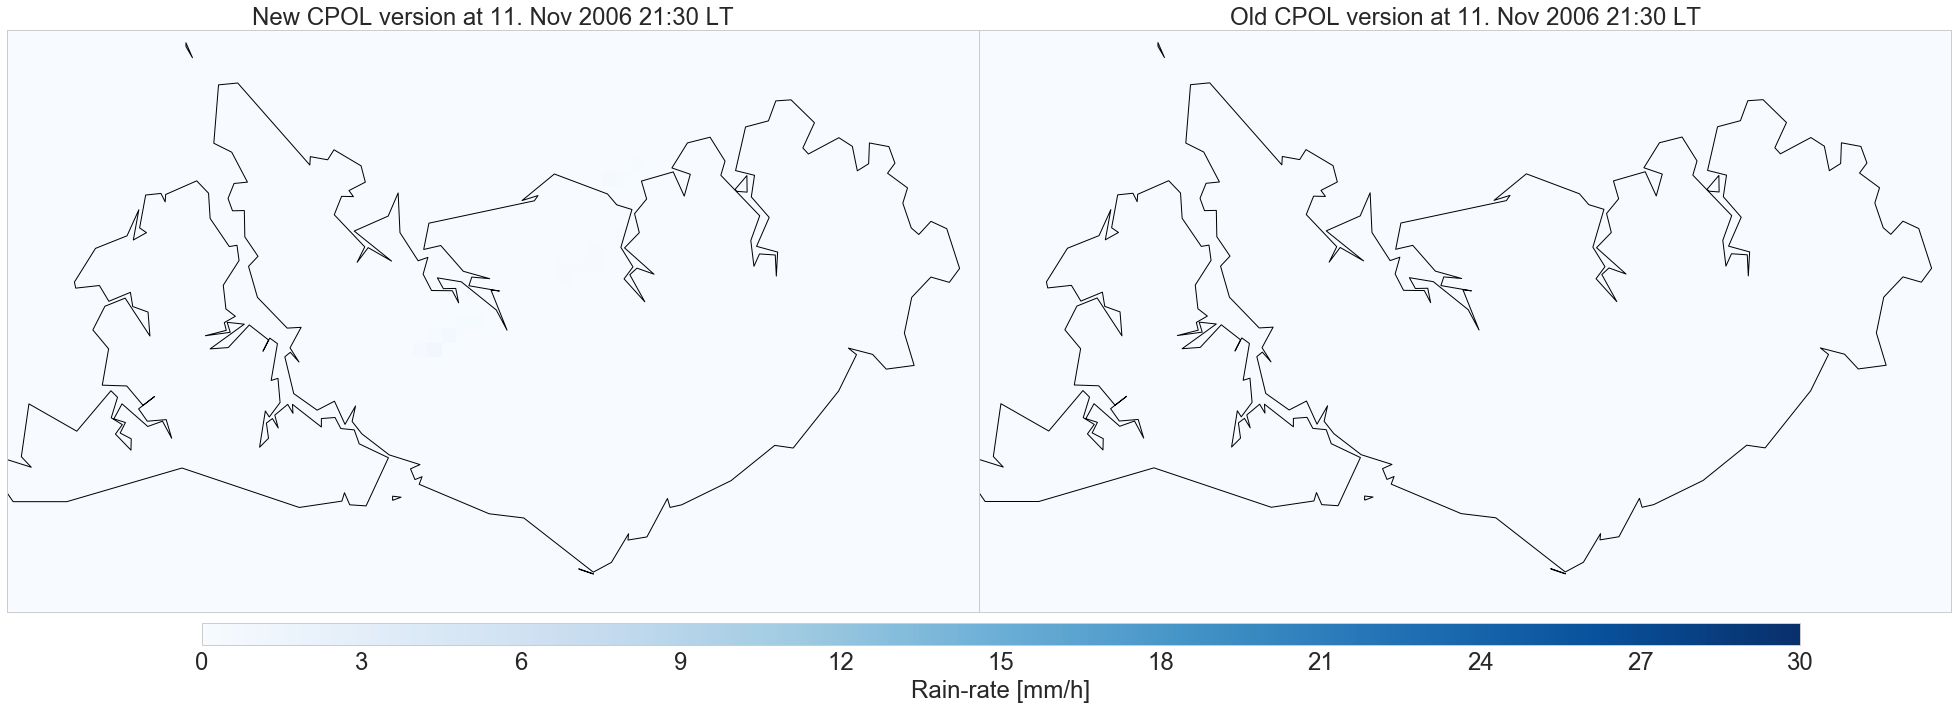

In [48]:
s##Intermezzo
first = True
fig = plt.figure()
fig.subplots_adjust(right=0.95, bottom=0.05, top=0.95,left=0.05, hspace=0, wspace=0)
data1 = np.ma.masked_less(OBS.dataset[-1].variables['lsrain'][:].values, 0.02)
data2 = np.ma.masked_less(OBS.dataset[1].variables['lsrain'][:].values, 0.02)
t1 = OBS.dataset[-1].variables['t'][:]
t2 = OBS.dataset[1].variables['t'][:]
tsteps = pd.DatetimeIndex(OBS.dataset[1].coords['t'].values).tz_localize(utc).tz_convert(timezone).to_pydatetime()
#for tt, tstep in enumerate(tsteps):
tt = 0
fname = os.path.join(outdir, 'Comparison_%05i.png'%tt)
#sys.stdout.flush()
#sys.stdout.write('\r Creating %s ....    '%os.path.basename(fname))
#sys.stdout.flush()
lon1, lat1 = OBS.dataset[-1].variables['longitude'][0,:], OBS.dataset[-1].variables['latitude'][:,0]
lon2, lat2 = OBS.dataset[1].variables['longitude'][0,:], OBS.dataset[1].variables['latitude'][:,0]
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
m1 = Basemap(llcrnrlat=min(lat1), llcrnrlon=min(lon1), urcrnrlat=max(lat1), urcrnrlon=max(lon1), resolution='i',
            area_thresh=1, ax=ax1)
m2 = Basemap(llcrnrlat=min(lat2), llcrnrlon=min(lon2), urcrnrlat=max(lat2), urcrnrlon=max(lon2), resolution='i',
            area_thresh=1, ax=ax2)
im1 = m1.pcolormesh(lon1, lat1, data1[tt].filled(-1),vmin=0.0,vmax=30,cmap='Blues')
im2 = m2.pcolormesh(lon2, lat2, data2[tt].filled(-1),vmin=0.0,vmax=30,cmap='Blues')
m1.drawcoastlines()
m2.drawcoastlines()
cbar_ax = fig.add_axes([0.14, 0.35, 0.74, 0.01])
cbar=fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('Rain-rate [mm/h]',size=24)
ax2.set_title('Old CPOL version at %s LT' %tsteps[tt].strftime('%d. %b %Y %H:%M'), fontsize=24)
ax1.set_title('New CPOL version at %s LT'%tsteps[tt].strftime('%d. %b %Y %H:%M'), fontsize=24)
def ani(tt):
    im1.set_array((data1[tt]).filled(-1).ravel())
    im2.set_array((data2[tt]).filled(-1).ravel())
    ax2.set_title('Old CPOL version at %s LT' %tsteps[tt].strftime('%d. %b %Y %H:%M'), fontsize=24)
    ax1.set_title('New CPOL version at %s LT'%tsteps[tt].strftime('%d. %b %Y %H:%M'), fontsize=24)
    return(im1, im2)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, ani, frames=100, interval=20, blit=True)
#fig.savefig(fname, bbox_inches='tight', format='png', dpi=72)
#break
#sys.stdout.write('\n')

In [20]:
import io
import base64
from IPython.display import HTML
outvid=os.path.join(outdir,'WeekOfHector.mp4')
video = io.open(outvid, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" width="950" height="500" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

### 2.1 Distribution of Percentiles during break and bursts

Now we compare the distributions of percentiles during break and burst periods. We also add 

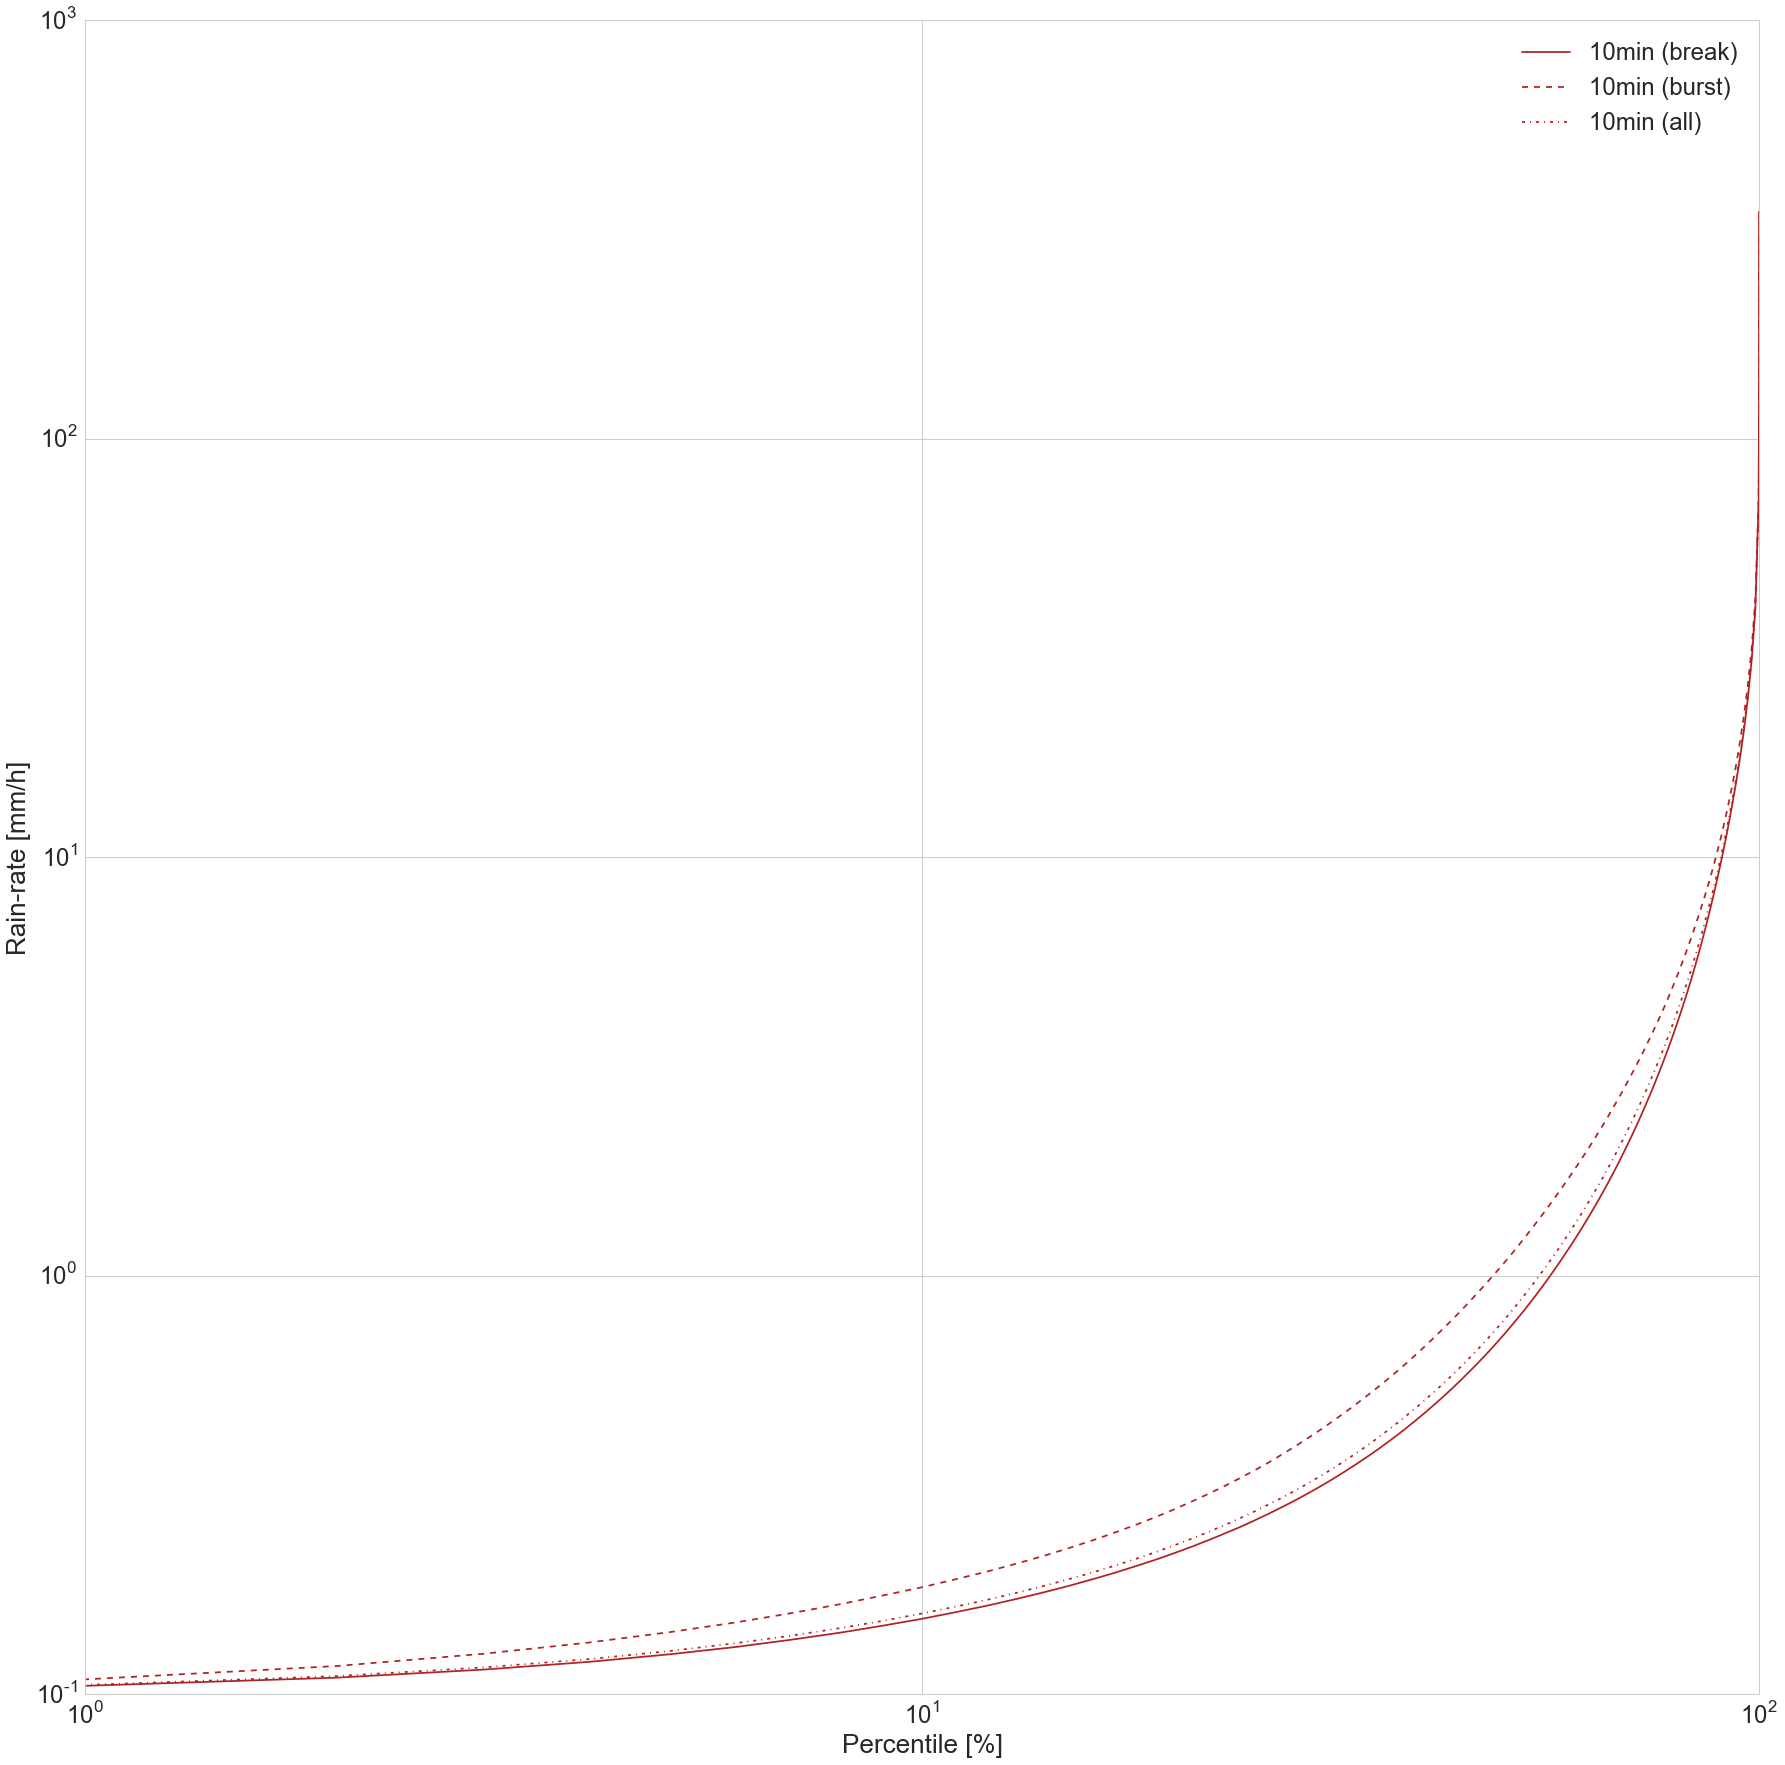

In [21]:
colors = {'10min':'firebrick'}# '1h':'lightseagreen', '3h':'fuchsia' , '6h':'cornflowerblue'}
fig=plt.figure()
ax = fig.add_subplot(111)
for con in (('break','-'), ('burst','--'), ('all','-.')):
    for gr in colors.keys():        
        df = pd.read_hdf(PercF, con[0])[gr]
        ax.plot(df.index, df.values, color=colors[gr], linestyle=con[-1], label='%s (%s)'%(gr, con[0]))
ax.set_xlim(1,99.9999)
#ax.set_ylim(0.11,)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Percentile [%]', fontsize=26)
ax.set_ylabel('Rain-rate [mm/h]', fontsize=26)
ax.legend(loc=0, fontsize=24)
ax.tick_params(labelsize=24)